# Análise preditiva

## Importando Bibliotecas

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignorar o aviso UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Importando e preparando dados

In [ ]:
data = pd.read_csv('MKT.csv')

## Conhecendo os dados

In [ ]:
data.dtypes

youtube      float64
facebook     float64
newspaper    float64
sales        float64
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   youtube    171 non-null    float64
 1   facebook   171 non-null    float64
 2   newspaper  171 non-null    float64
 3   sales      171 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [ ]:
data.describe()

,youtube,facebook,newspaper,sales
count,171.000000,171.000000,171.000000,171.000000
mean,178.021053,27.671579,35.240000,16.922807
std,102.449597,17.913532,24.902918,6.314608
min,0.840000,0.000000,0.360000,1.920000
25%,91.080000,11.700000,13.740000,12.540000
50%,179.760000,26.760000,31.080000,15.480000
75%,262.980000,43.680000,50.880000,20.820000
max,355.680000,59.520000,121.080000,32.400000


## Tratando

### Definindo funções

Formulas de normalização

In [ ]:
# Retorna um dataframe com dados de vendas normalizados
def media_movel(df, sort, normalize, range_normalize=3, filter=True):
  df_out = df.copy()
  if filter:
    df_out = df_out[[sort, normalize]]
  df_out.sort_values(sort, inplace=True)
  df_out[f'media_movel_{normalize}'] = [sum(df_out[normalize].iloc[i-range_normalize:i+range_normalize]) if i+range_normalize < len(df_out) and i-range_normalize >= 0 else None for i in range(len(df_out))]
  return df_out

# Retorna um gráfico de linha com dados de vendas normalizados
def normalized_line(df, x, y, normalize_range=3):
  df_out = media_movel(df, x, y, normalize_range)
  sns.lineplot(data=df_out, x=x, y=f'media_movel_{y}')

Formula de correlação

In [ ]:
def calcular_correlacao_e_p(df):
    # Calcula a matriz de correlação e p-valores
    matriz_corr = df.corr()

    # Inicializa uma matriz para armazenar os p-valores
    matriz_p = pd.DataFrame(index=df.columns, columns=df.columns)

    # Preenche a matriz de p-valores
    for i in df.columns:
        for j in df.columns:
            corr, p_valor = pearsonr(df[i], df[j])
            matriz_corr.at[i, j] = corr
            matriz_p.at[i, j] = p_valor

    return matriz_corr, matriz_p

### Visualizando os dados

Gráficos normalizados relacionando vendas com investimentos em plataformas

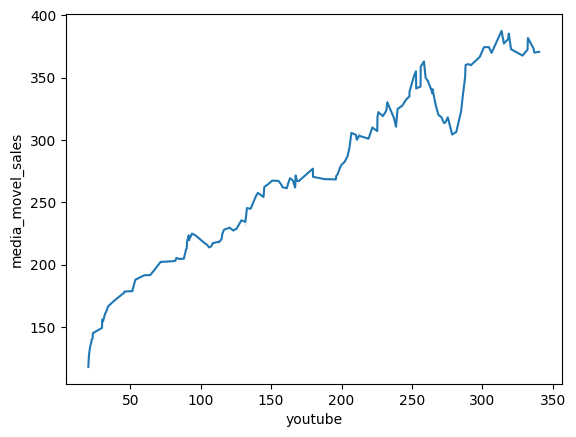

In [ ]:
normalized_line(df=data, x='youtube', y='sales', normalize_range=8)

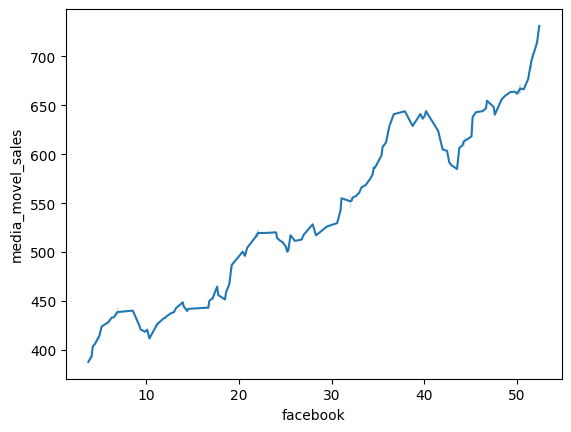

In [ ]:
normalized_line(df=data, x='facebook', y='sales', normalize_range=16)

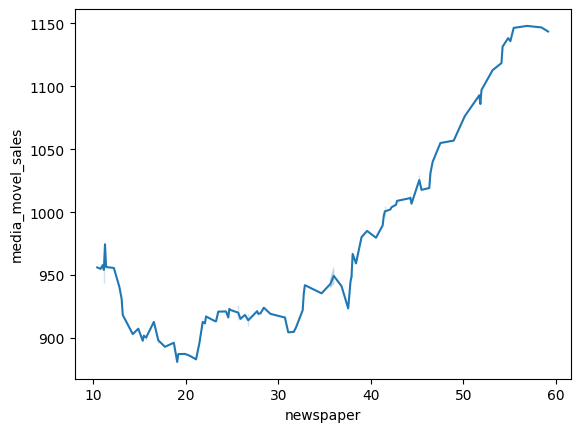

In [ ]:
normalized_line(df=data, x='newspaper', y='sales', normalize_range=30)

Correlações entre as colunas

In [ ]:
cor_data = calcular_correlacao_e_p(data)

In [ ]:
cor_data[1]

,youtube,facebook,newspaper,sales
youtube,0.0,0.260399,0.14925,0.0
facebook,0.260399,0.0,0.000098,0.0
newspaper,0.14925,0.000098,0.0,0.000763
sales,0.0,0.0,0.000763,0.0


In [ ]:
cor_data[0]

,youtube,facebook,newspaper,sales
youtube,1.000000,0.086538,0.110759,0.782030
facebook,0.086538,1.000000,0.293425,0.602918
newspaper,0.110759,0.293425,1.000000,0.254987
sales,0.782030,0.602918,0.254987,1.000000


Distribuição de investimentos e vendas

<Axes: >

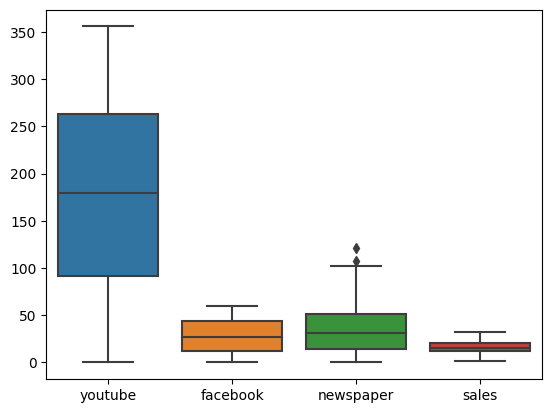

In [ ]:
sns.boxplot(data)

## Criando o modelos

In [ ]:
# Dicionário de modelos
modelos = {}

# Plataformas (colunas)
plataformas = ['youtube', 'facebook', 'newspaper']

for plataforma in plataformas:

  # Variáveis
  melhor_r2 = 0
  melhor_modelo = None
  melhor_mse = None
  melhor_range = None

  # Teste qual o melhor range para média móvel
  for i in range(20):

    # Quo é coeficiennte que multiplica o produto da divisão do desvio padrão pela média para
    # comparar com o desvio padrão pelo valor e filtrar os dados
    for quo in np.arange(0, 4.1, 0.1):

      # start_news é o ponto de onde iniciarão as predições de newspaper: pelos gráficos, a relação entre as variáveis não iniciaria
      # desde o princípio da série
      for start_news in range(50):
        if start_news == 0 or plataforma == 'newspaper':

          # Criar conjunto de dados com média móvel e filtros
          if i > 0:
            if plataforma == 'newspaper':
              conjunto = media_movel(data[data[plataforma]>start_news], plataforma, 'sales', range_normalize=i, filter=False)
            else:
              conjunto = media_movel(data, plataforma, 'sales', range_normalize=i, filter=False)
              if plataforma == 'newspaper':
                conjunto = conjunto[conjunto[plataforma]>start_news]
          else:
            conjunto = data.copy()
            if plataforma == 'newspaper':
              conjunto = conjunto[conjunto[plataforma]>start_news]
          conjunto.dropna(inplace=True)

          for plataforma_filtro in plataformas:
            if plataforma_filtro != plataforma:
              conjunto = conjunto[(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro]>=(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro].mean())*(1-quo)) &
                                  (conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro]<=(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro].mean())*(1+quo))]

          if len(conjunto) > 50:

            X = conjunto[plataforma].values.reshape(-1, 1)
            y = conjunto['sales']  # Agora, treinamos e prevemos 'sales'

            try:
              # Dividir os dados em conjuntos de treinamento e teste
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

              # Criar um modelo de regressão linear
              modelo = LinearRegression()

              # Treinar o modelo
              modelo.fit(X_train, y_train)

              # Fazer previsões no conjunto de teste
              y_pred = modelo.predict(X_test)

              # Avaliar o modelo usando R²
              r2 = r2_score(y_test, y_pred)

              # Atualizar o melhor modelo se o R² atual for maior
              if r2 > melhor_r2:
                  melhor_r2 = r2
                  melhor_modelo = modelo
                  melhor_mse = mean_squared_error(y_test, y_pred)
                  melhor_range = i
                  melhor_quo = quo
                  melhor_start = start_news
            except ValueError:
              pass

  # Armazenar o melhor modelo para a plataforma
  modelos[plataforma] = melhor_modelo

  # Exibir os parâmetros e métricas do melhor modelo
  print(f"\n{plataforma}")
  print(f"Coeficiente Angular: {melhor_modelo.coef_[0]}")
  print(f"Intercepto: {melhor_modelo.intercept_}")
  print(f"Erro Quadrático Médio (MSE): {melhor_mse}")
  print(f"Coeficiente de Determinação (R²): {melhor_r2}")
  print(f"Melhor Range: {melhor_range}")
  print(f"Melhor Quo: {melhor_quo}")
  print(f"Melhor Start: {melhor_start}")



youtube
Coeficiente Angular: 0.05383804161236524
Intercepto: 9.459406726019349
Erro Quadrático Médio (MSE): 4.201930867992625
Coeficiente de Determinação (R²): 0.9264483220420496
Melhor Range: 3
Melhor Quo: 0.7000000000000001
Melhor Start: 0

facebook
Coeficiente Angular: 0.25335731795297267
Intercepto: 12.23030204859197
Erro Quadrático Médio (MSE): 3.01968834241245
Coeficiente de Determinação (R²): 0.8956776385332145
Melhor Range: 10
Melhor Quo: 1.0
Melhor Start: 0


<ipython-input-17-249f6bd908d5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto.dropna(inplace=True)
<ipython-input-17-249f6bd908d5>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conjunto.dropna(inplace=True)



newspaper
Coeficiente Angular: 0.1116913090082647
Intercepto: 14.931025419007057
Erro Quadrático Médio (MSE): 12.884568435909259
Coeficiente de Determinação (R²): 0.4133431483419955
Melhor Range: 8
Melhor Quo: 1.6
Melhor Start: 23


<Axes: xlabel='youtube_dif_to_mean', ylabel='newspaper_error'>

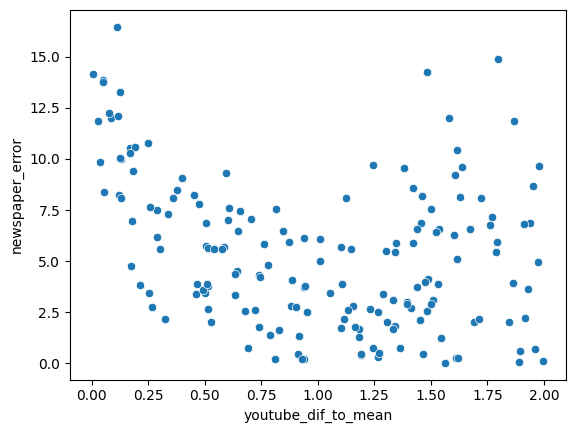

In [ ]:
# Visualização que implicou na remoção de dados demaziado distantes do desvio padrão
for plataforma in plataformas:
    data[f'{plataforma}_predict'] = modelos[plataforma].predict(data[plataforma].values.reshape(-1, 1))
    data[f'{plataforma}_error'] = abs(data[f'{plataforma}_predict'] - data['sales'])
    data[f'{plataforma}_dif_to_mean'] = data[plataforma]/np.mean(data[plataforma])
sns.scatterplot(data[['newspaper_error', 'youtube_dif_to_mean']], x='youtube_dif_to_mean', y='newspaper_error')

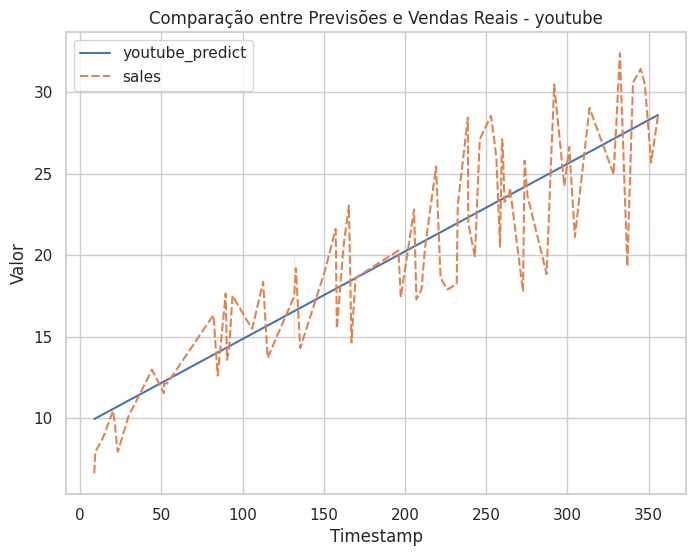

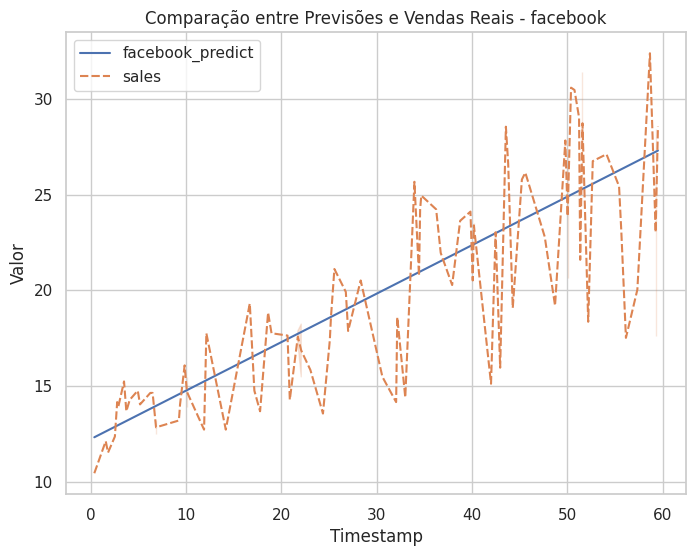

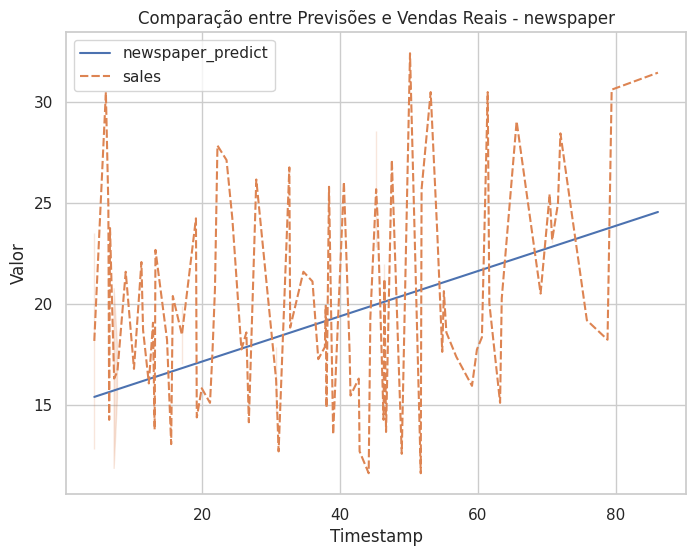

In [ ]:
# Demonstrações do modelo em gráficos normalizados e removidos outliers
sns.set(style="whitegrid")
start_news = 0

for plataforma in plataformas:
  if plataforma == 'youtube':
    quo = 0.7
    i = 3
  elif plataforma == 'facebook':
    quo = 1
    i = 10
  else:
    quo = 1.6
    i = 8
  if plataforma == 'newspaper':
      conjunto = media_movel(data[data[plataforma]>start_news], plataforma, 'sales', range_normalize=i, filter=False)
  else:
    conjunto = media_movel(data, plataforma, 'sales', range_normalize=i, filter=False)
    if plataforma == 'newspaper':
      conjunto = conjunto[conjunto[plataforma]>start_news]
    else:
      conjunto = data.copy()
      if plataforma == 'newspaper':
        conjunto = conjunto[conjunto[plataforma]>start_news]
  conjunto.dropna(inplace=True)

  for plataforma_filtro in plataformas:
    if plataforma_filtro != plataforma:
      conjunto = conjunto[(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro]>=(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro].mean())*(1-quo)) &
                          (conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro]<=(conjunto[plataforma_filtro].std()/conjunto[plataforma_filtro].mean())*(1+quo))]
  plt.figure(figsize=(8, 6))
  conjunto.index = conjunto[plataforma]
  sns.lineplot(data=conjunto[[f'{plataforma}_predict', 'sales']])
  plt.title(f'Comparação entre Previsões e Vendas Reais - {plataforma}')
  plt.xlabel('Timestamp')
  plt.ylabel('Valor')
  plt.show()